In [3]:
import xarray as xr
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import echopype as ep

# Download dataset
Download netcdf dataset from imos-data/IMOS/SOOP/SOOP-BA/VLMJ_Investigator/

In [4]:
fname = './data/GLIDER_SB_2018_v5-Phase0-D20180625-T104250-2.nc'
ed = ep.open_converted(fname)
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')
ds

<xarray.Dataset>
Dimensions:                (ping_time: 96, frequency: 1, range_bin: 25296)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2018-06-25T10:42:50.967...
  * frequency              (frequency) float64 3.33e+05
  * range_bin              (range_bin) int32 0 1 2 3 ... 25292 25293 25294 25295
Data variables:
    Sv                     (frequency, ping_time, range_bin) float64 nan ... ...
    range                  (frequency, ping_time, range_bin) float64 0.0 ... ...
    temperature            (ping_time) float64 8.0 nan nan nan ... nan nan nan
    salinity               (ping_time) float64 35.0 nan nan nan ... nan nan nan
    pressure               (ping_time) float64 5.0 nan nan nan ... nan nan nan
    sound_speed            (ping_time) float64 1.482e+03 nan nan ... nan nan nan
    sound_absorption       (ping_time, frequency) float64 0.08015 nan ... nan
    sa_correction          object None
    gain_correction        object None
    equivalent_beam_angle  (frequency) float64 ...

In [12]:
#ds.coords['range_bin']=np.array(ds.range[0,0,:]) # replace range bin with depth value/range

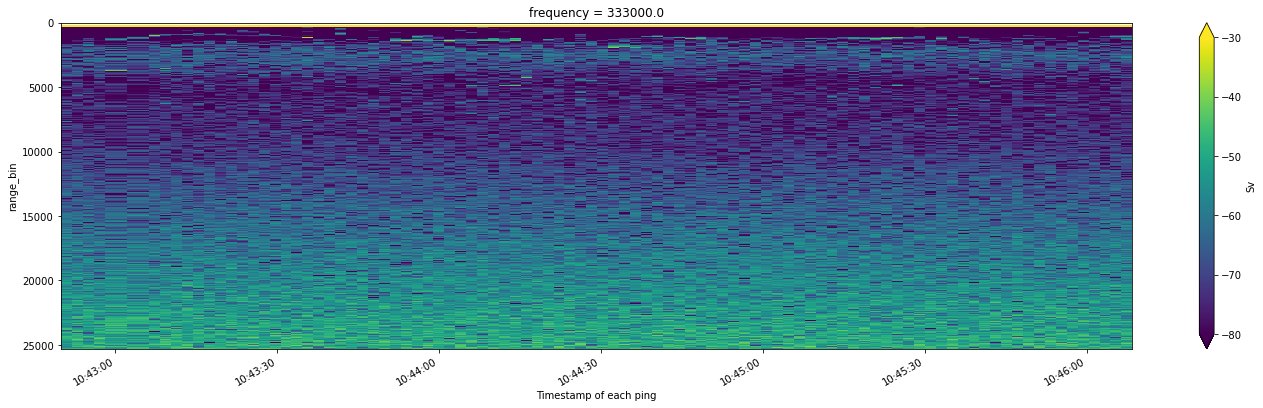

In [5]:
fig = (ds.Sv).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# Get layers of interest

Working on one channel at a time so please select the channel first

In [6]:
ds_s = ds[['Sv']].isel(frequency=0,range_bin=slice(300,10000), ping_time=slice(0,30))
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2...
    frequency  float64 3.33e+05
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -15.82 -24.66 ... -88.4 -67.94

## Interpolation along DEPTH axis and drop all nan slices in TIME

In [7]:
ds_s = ds_s.dropna('ping_time', how='all')
ds_s = ds_s.dropna('range_bin', how='all')
ds_s = ds_s.interpolate_na('range_bin', method="linear")
ds_s = ds_s.dropna('range_bin', how='any')
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -15.82 -24.66 ... -88.4 -67.94

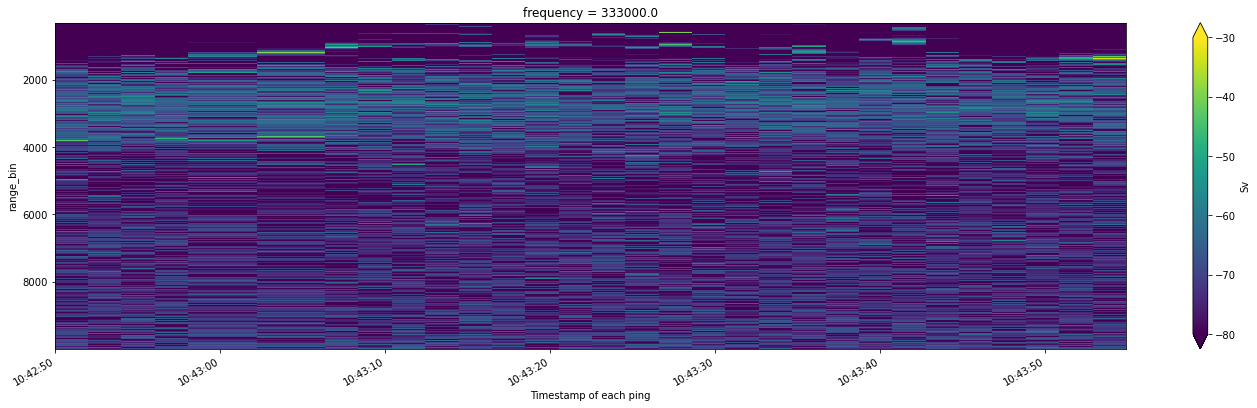

In [99]:
fig = ds_s.Sv.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30).figure
plt.gca().invert_yaxis()

In [100]:
fig.savefig('initial_img.png')

In [10]:
ds_s['Sv']

<xarray.DataArray 'Sv' (ping_time: 30, range_bin: 9700)>
array([[-15.82101509, -24.65774021, -19.42508328, ..., -71.65767585,
        -70.80932257, -87.38127627],
       [-16.97435239, -22.06331558, -19.89553585, ..., -71.80237961,
        -77.38324841, -72.83226394],
       [-16.64404256, -25.44737238, -20.33462211, ..., -77.44589343,
        -70.42472632, -71.63601132],
       ...,
       [-15.96370915, -20.16567032, -16.86019101, ..., -70.46702908,
        -68.34942467, -65.73478559],
       [-17.0597543 , -22.37069768, -19.69058774, ..., -69.49156946,
        -74.47483995, -70.40498355],
       [-16.98936549, -19.59364041, -17.86763093, ..., -66.02711553,
        -88.4024171 , -67.94371506]])
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999

## Using mean filtering to smooth the image and remove noise

window depth=194
window time=6
time min init: 2018-06-25T10:42:50.967000064, max: 2018-06-25T10:43:53.880999936
len time: 30
time min smooth: 2018-06-25T10:42:50.967000064, max: 2018-06-25T10:43:53.880999936
len time smooth: 30


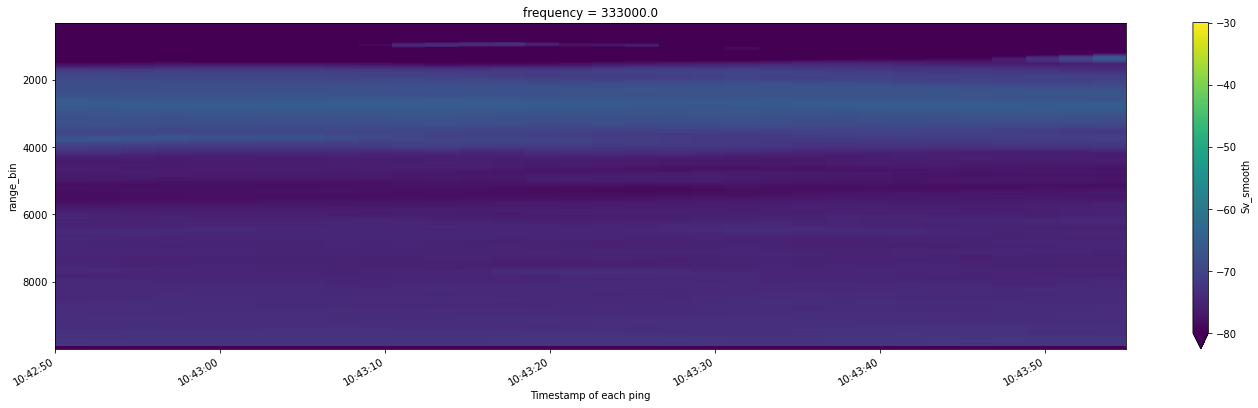

In [112]:
time_smoothing = max(len(ds_s['ping_time'].data)//5, 1)
depth_smoothing = len(ds_s['range_bin'].data)//50
print(f'window depth={depth_smoothing}')
print(f'window time={time_smoothing}')
print(f"time min init: {ds_s['ping_time'].min().data}, max: {ds_s['ping_time'].max().data}")
print(f"len time: {len(ds_s['ping_time'])}")

# smoothing on time axis
Sv_smooth = ds_s['Sv'].pad(ping_time=(time_smoothing, time_smoothing), mode='edge').rolling(ping_time=time_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(ping_time=np.arange(time_smoothing, len(ds_s['ping_time'])+time_smoothing))

# smoothing on depth axis
Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='constant', constant_values=ds_s['Sv'].min()).rolling(range_bin=depth_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(range_bin=np.arange(depth_smoothing, len(ds_s['range_bin'])+depth_smoothing))

print(f"time min smooth: {Sv_smooth['ping_time'].min().data}, max: {Sv_smooth['ping_time'].max().data}")
print(f"len time smooth: {len(Sv_smooth['ping_time'])}")

ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth.data)})
fig = ds_s.Sv_smooth.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

In [114]:
fig.figure.savefig('smooth.png')

# Simple thresholding using the mean

In [105]:
thresh_window = len(ds_s['range_bin'].data)//5

thresh = ds_s['Sv'].mean(dim='ping_time').pad(range_bin=(thresh_window, thresh_window), mode='edge').rolling(range_bin=thresh_window, center=True).mean()
thresh = thresh.isel(range_bin=np.arange(thresh_window, len(ds_s['range_bin'])+thresh_window))

# thresh = ds_s['Sv'].mean(dim='ping_time')
# thresh = thresh.mean()
thresh

<xarray.DataArray 'Sv' (range_bin: 9700)>
array([-53.54513568, -53.57994909, -53.61436859, ..., -72.47034319,
       -72.469728  , -72.46970596])
Coordinates:
    frequency  float64 3.33e+05
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999

In [117]:
thresh_window

1940

In [106]:
ds_s['Sv'].mean()

<xarray.DataArray 'Sv' ()>
array(-75.11383868)
Coordinates:
    frequency  float64 3.33e+05

In [107]:
ds_s = ds_s.assign(variables={"Sv_mask": (('ping_time', 'range_bin'), (ds_s['Sv_smooth'].data>thresh.data))})
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -15.82 -24.66 ... -88.4 -67.94
    Sv_smooth  (ping_time, range_bin) float64 -106.5 -106.3 ... -102.2 -102.5
    Sv_mask    (ping_time, range_bin) bool False False False ... False False

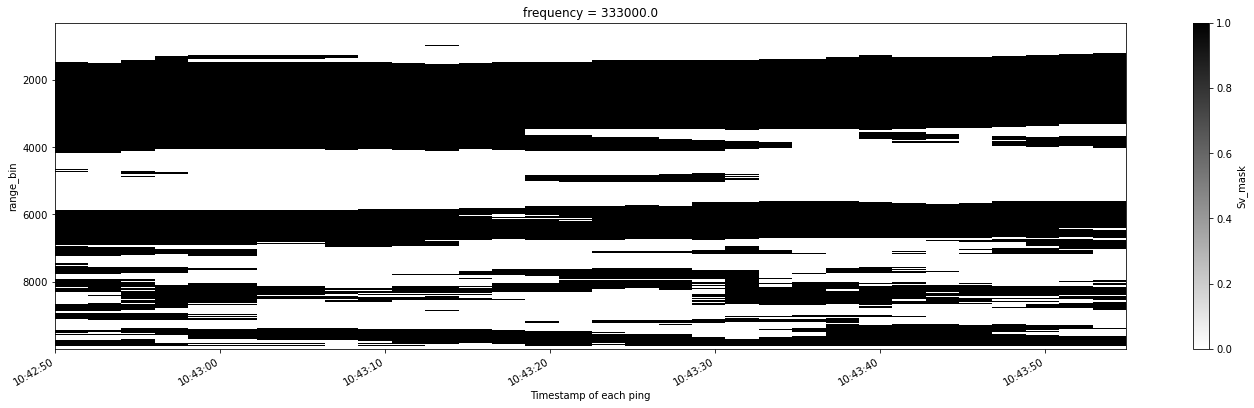

In [115]:
fig = ds_s["Sv_mask"].plot(x='ping_time', size=6, aspect=4, cmap="binary").figure
plt.gca().invert_yaxis()

In [116]:
fig.savefig('masked_thresh.png')

# Edge detection

Using canny filtering to get the edges of the layers

In [104]:
from skimage import feature
edges = feature.canny(ds_s['Sv_mask'].data, sigma=11)
ds_s = ds_s.assign(variables={"edges": (('ping_time', 'range_bin'), edges)})

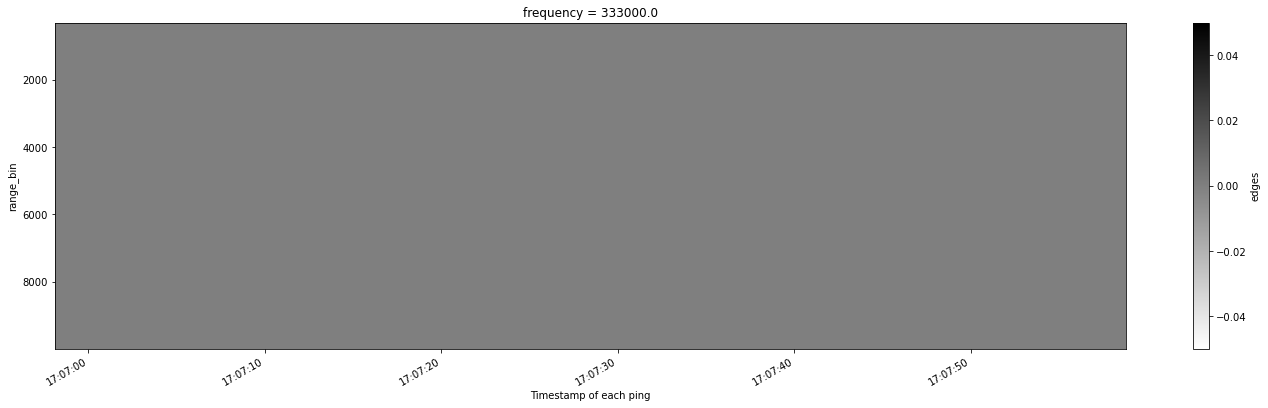

In [105]:
fig = ds_s["edges"].plot(x='ping_time', size=6, aspect=4, cmap="binary").figure
plt.gca().invert_yaxis()

In [106]:
fig.savefig('contours.png')

# Apply mask on initial image

In [107]:
filtered = ds_s['Sv'].where(ds_s['Sv_mask'])
filtered

<xarray.DataArray 'Sv' (ping_time: 30, range_bin: 9700)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T17:06:59.104000 ... 2018...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999

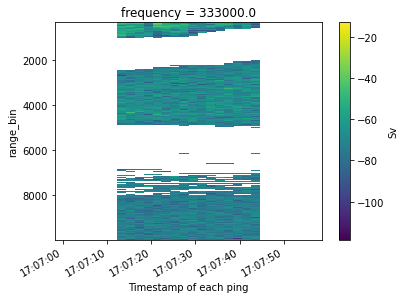

In [114]:
fig = (filtered).plot(x='ping_time', cmap="viridis").figure
plt.gca().invert_yaxis()

In [110]:
fig.savefig('mask_applied.png')

## Adding edges on the initial image

not sure how to have both overlay 

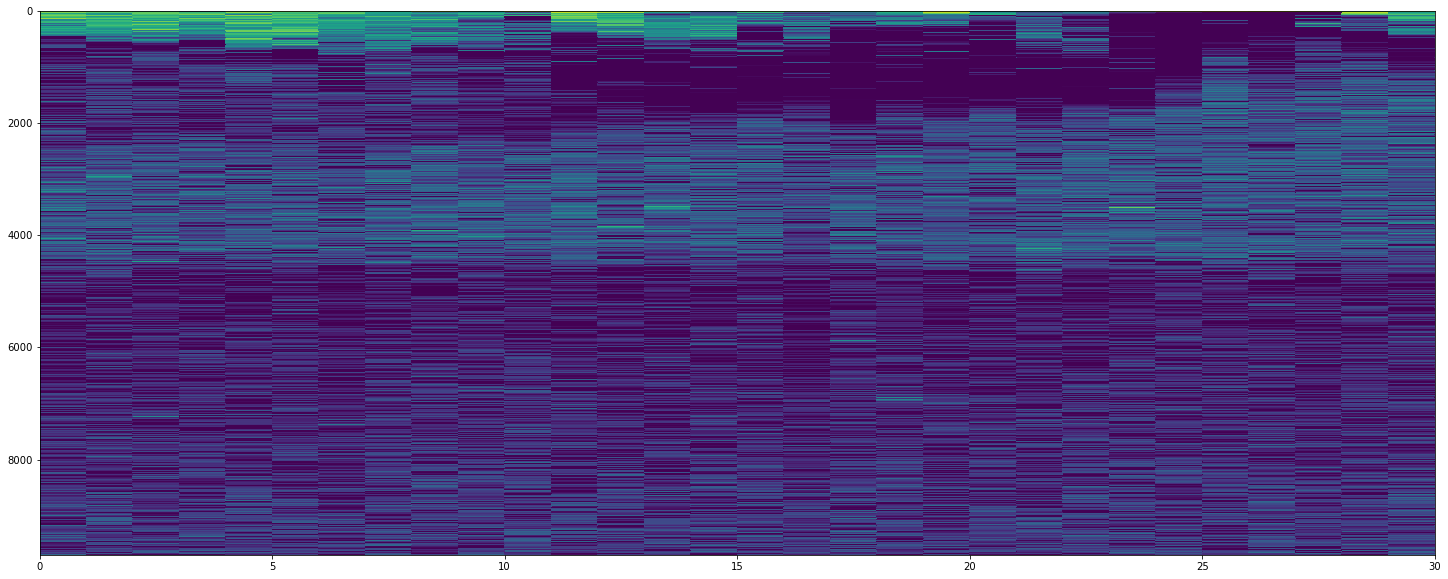

In [122]:
fig, ax = plt.subplots(figsize = (25,10))
ax.pcolormesh(ds_s["Sv"].data.T, cmap="viridis", vmax=-30, vmin=-80)
#ax.pcolormesh(ds_s['edges'].T, cmap="binary")
plt.gca().invert_yaxis()

# Other methods

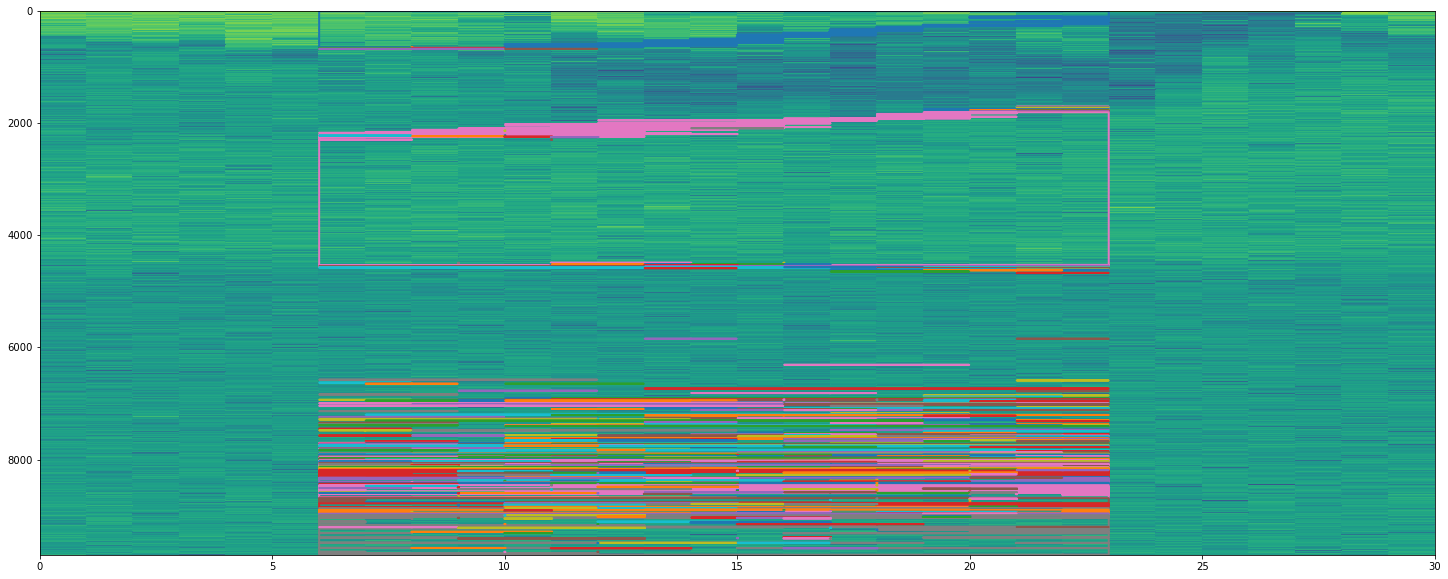

In [123]:
from skimage import measure

# Find contours at a constant value of 0.8
r = ds_s["Sv_mask"].data.T
contours = measure.find_contours(r, 0.01)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize = (25,10))
ax.pcolormesh(ds_s["Sv"].data.T)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.invert_yaxis()
plt.show()

C:\Users\mbd\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if __name__ == '__main__':


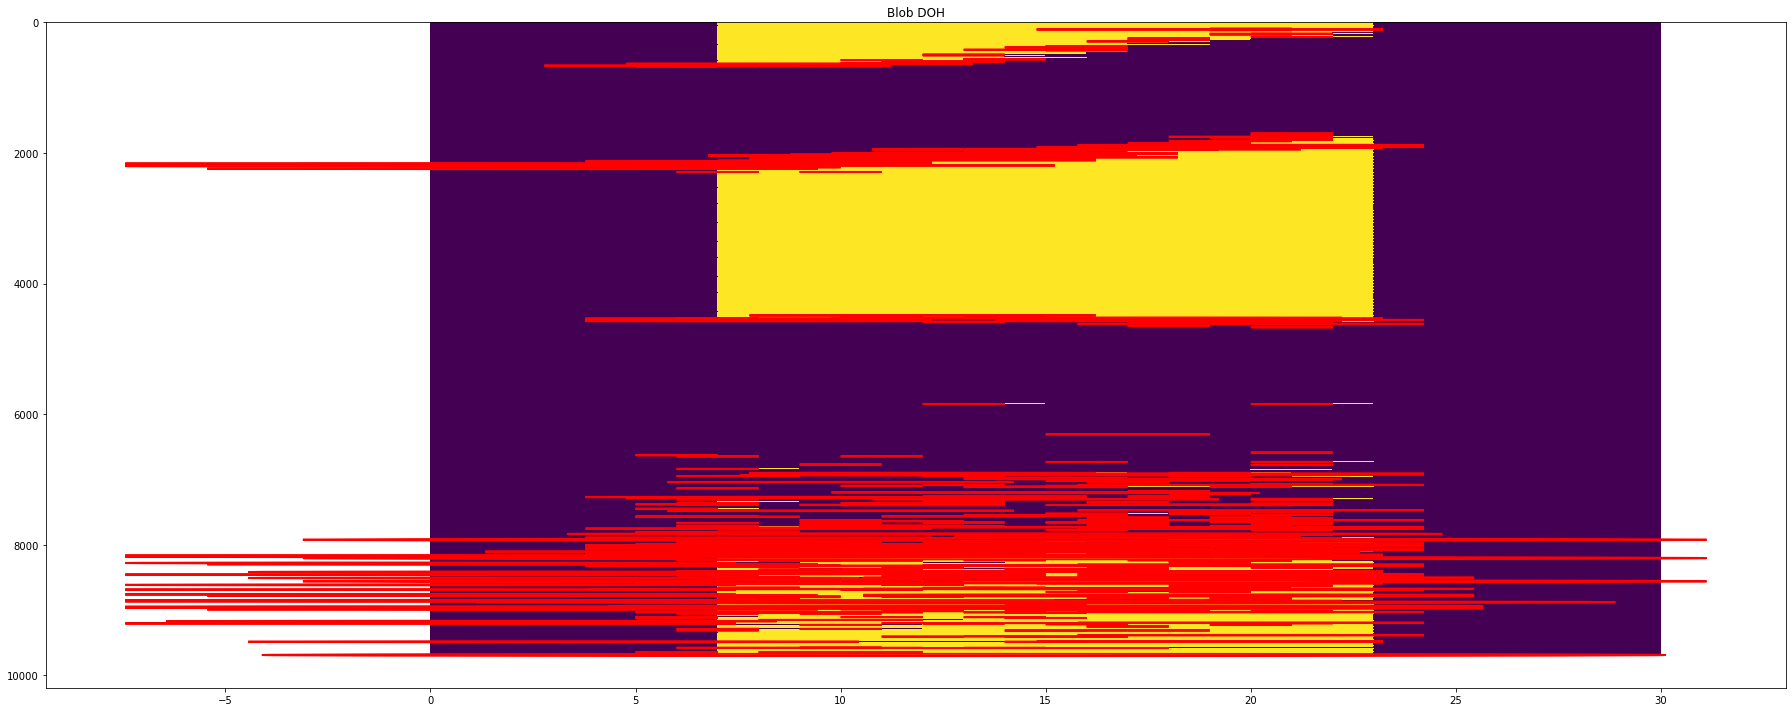

In [124]:
from math import sqrt
from skimage.feature import blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = ds_s['Sv_mask'].T
image_gray = rgb2gray(image)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.02)

fig, ax = plt.subplots(figsize = (25,10))
ax.set_title("Blob DOH")
ax.pcolormesh(image)
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Ressources to other methods

* Trained classifier (random forest): https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py

* Marching suqares algorithm: https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py

* Blob Determinant of Hessian method: https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_doh
